In [1]:
import zipfile
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import  SMOTE
import numpy as np

### Reference article for Gini: https://link.springer.com/article/10.1057/dbm.2010.2 
#### I am familiar with use of AUC/ROC for model evaluation. I needed to understand how that relates to Gini

In [2]:
account_train = pd.read_csv('./Data/raw_account_70_new.csv',low_memory=False)
data_train = pd.read_csv('./Data/raw_data_70_new.csv',low_memory=False)
enquiry_train = pd.read_csv('./Data/raw_enquiry_70_new.csv',low_memory=False)

In [3]:
account_train.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,...,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900.0,...,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,NaN,03-Oct-15,16201.0,...,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,NaN,30-Sep-15,41028.0,...,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,NaN,26-Jul-07,31-Jan-09,93473.0,...,NaN,"""""""1200900600600600300000000000000000000000000...",NaN,01-Jul-07,01-Feb-06,NaN,NaN,NaN,NaN,NaN
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,NaN,31-May-15,20250.0,...,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN


In [4]:
enquiry_train.head()

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,18-Apr-15,1,21-Apr-15,19-Dec-14,2.0,3500000.0
1,18-Apr-15,1,21-Apr-15,5-Mar-14,5.0,500000.0
2,18-Apr-15,1,21-Apr-15,5-Mar-14,0.0,50000.0
3,18-Apr-15,1,21-Apr-15,22-Feb-14,10.0,50000.0
4,18-Apr-15,1,21-Apr-15,11-Jun-13,10.0,1000.0


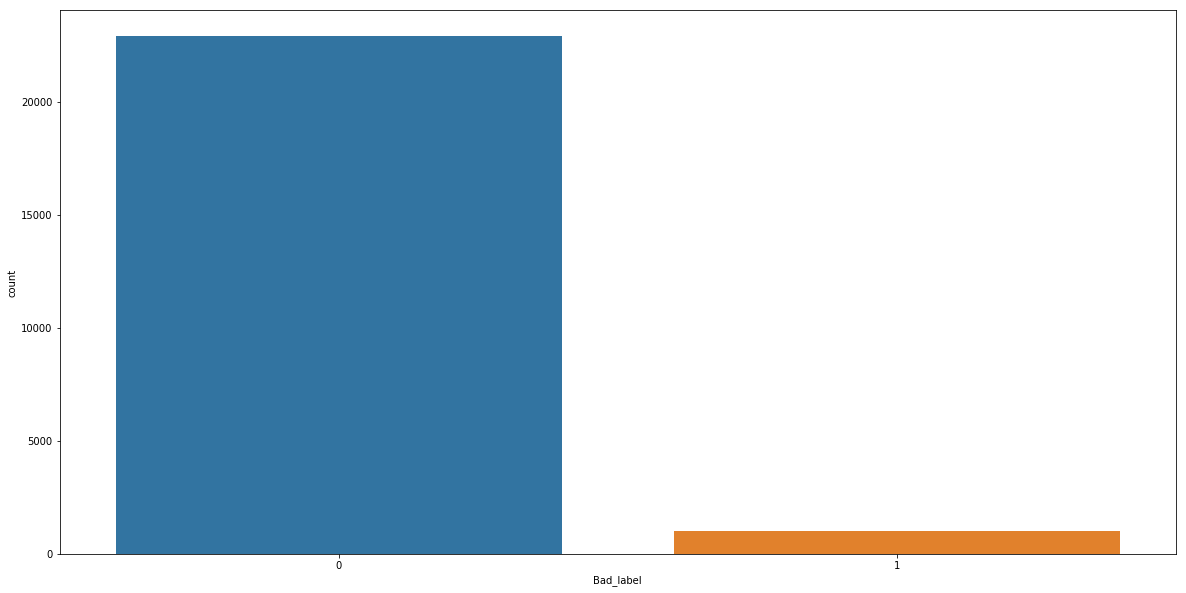

In [5]:
plt.figure(figsize=(20,10))
sns.countplot(data_train.Bad_label)

In [6]:
class Feature_Engineer:
    def __init__(self,account,enquiry):
        import pandas as pd
        self.accounts = account
        self.accounts = self.accounts[['customer_no','paymenthistory1','paymenthistory2']]
        self.account = self.temp_clean(self.accounts)
        
    def clean_paymenthistorystring(self,x):
        return(x.replace('"','').replace('nan',''))
    def check_if_dpd_0_29(self,x):
        n=3
        y =[x[i:i+n] for i in range(0, len(x), n)]
        for element in y:
            if element =='SMA' or element == 'SUB' or element == 'DBT' or element == 'LSS':
                return(0)
            if element == '000' or element == 'STD' or element == 'XXX':
                pass
            elif int(element)<30:
                pass
            else:
                return(0)
        return(1)
    
    def temp_clean(self,df):
        df['paymenthistory1'] = df['paymenthistory1'].astype(str).apply(lambda x: self.clean_paymenthistorystring(x))
        df['paymenthistory1'] = df['paymenthistory1'].astype(str).apply(lambda x: self.clean_paymenthistorystring(x))
        df['paymenthistory2'] = df['paymenthistory2'].astype(str).apply(lambda x: self.clean_paymenthistorystring(x))
        df['paymenthistory'] = df['paymenthistory1'] + df['paymenthistory2']
        df['paymenthistory'] = df['paymenthistory'].astype(str)
        df['is_dpd_0_29'] = df['paymenthistory'].apply(lambda x: self.check_if_dpd_0_29(x))
        return df
    def calc_payment_history_avg_dpd_0_29_bucket(self,customer_no):
        df = self.account[self.account['customer_no']==customer_no]
        return(sum(df['is_dpd_0_29'] ))
    def put_history_avg_dpd_0_29_bucket_in_df(self,df):
        df['payment_history_avg_dpd_0_29_bucket'] = df['customer_no'].apply(lambda x: self.calc_payment_history_avg_dpd_0_29_bucket(x))
        return df
    


In [7]:
fe = Feature_Engineer(account_train,enquiry_train)

C:\Users\PatwaV01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\PatwaV01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\PatwaV01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [8]:
data_train_trans = fe.put_history_avg_dpd_0_29_bucket_in_df(data_train)



In [9]:
data_train_trans.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,payment_history_avg_dpd_0_29_bucket
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0,17
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,R,NaN,NaN,0000-00-00,0.0,99455XXXXX,1.0,N,0,2
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,R,NaN,NaN,0000-00-00,0.0,98456XXXXX,1.0,N,0,1
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,R,NaN,NaN,6/15/65,1.0,98220XXXXX,1.0,N,0,14
4,6-May-15,5,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,500000.0,...,R,NaN,NaN,0000-00-00,0.0,98111XXXXX,1.0,N,0,7


In [10]:
account_test = pd.read_csv('./Data/raw_account_30_new.csv',low_memory=False)
data_test = pd.read_csv('./Data/raw_data_30_new.csv',low_memory=False)
enquiry_test = pd.read_csv('./Data/raw_enquiry_30_new.csv',low_memory=False)

In [11]:
fe_test = Feature_Engineer(account_test,enquiry_test)

C:\Users\PatwaV01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\PatwaV01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\PatwaV01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [12]:
data_test_trans = fe.put_history_avg_dpd_0_29_bucket_in_df(data_test)

In [13]:
data_test_trans.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,payment_history_avg_dpd_0_29_bucket
0,21-Apr-15,1,17-Apr-15,Insignia,17-Apr-15,726.0,1.0,Card Setup,14.0,1200000.0,...,R,NaN,NaN,0000-00-00,0.0,98220XXXXX,1.0,N,0,17
1,12-May-15,2,6-May-15,Insignia,6-May-15,844.0,1.0,Card Setup,14.0,300000.0,...,R,NaN,NaN,0000-00-00,0.0,98308XXXXX,1.0,N,0,2
2,21-May-15,3,20-May-15,Insignia,20-May-15,723.0,3.0,Card Setup,14.0,1500000.0,...,R,NaN,NaN,0000-00-00,0.0,98107XXXXX,1.0,N,0,1
3,22-May-15,4,22-May-15,Insignia,22-May-15,778.0,1.0,Card Setup,14.0,2500000.0,...,O,NaN,NaN,0000-00-00,0.0,98100XXXXX,1.0,N,0,14
4,22-May-15,5,12-May-15,Insignia,13-May-15,810.0,1.0,Card Setup,14.0,500000.0,...,R,NaN,NaN,1/31/44,1.0,98202XXXXX,2.0,N,0,7


In [ ]:
import time.ti

In [21]:
int((pd.to_datetime('2017-08-12') - pd.to_datetime('2017-08-13')).days)

-1

In [26]:
(pd.to_datetime('2017-08-12') - pd.to_datetime('')).days

nan

In [14]:
#data = data_train.iloc[0:10]

In [15]:
data_train.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,payment_history_avg_dpd_0_29_bucket
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,...,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0,17
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,...,R,NaN,NaN,0000-00-00,0.0,99455XXXXX,1.0,N,0,2
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,...,R,NaN,NaN,0000-00-00,0.0,98456XXXXX,1.0,N,0,1
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,...,R,NaN,NaN,6/15/65,1.0,98220XXXXX,1.0,N,0,14
4,6-May-15,5,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,500000.0,...,R,NaN,NaN,0000-00-00,0.0,98111XXXXX,1.0,N,0,7
